**AutoML OSS入門（4）**

# AutoMLを最短3行で！表形式や画像、テキストのデータにも対応可能なOSS「AutoGluon」

本ノートブックの紹介記事と併せてご覧ください。
- ＠IT連載 AutoML OSS入門（4）- 第4回「AutoMLを最短3行で！表形式や画像、テキストのデータにも対応可能なOSS「AutoGluon」」

また、ノートブックの扱い方やタイタニックの生存予測データについては、連載記事の第1回も参照してください。
- [＠IT連載 AutoML OSS入門（１）- 第1回「機械学習モデル構築作業の煩雑さを解消する「AutoML」とは――歴史、動向、利用のメリットを整理する」](https://www.atmarkit.co.jp/ait/articles/2107/02/news006.html)

## タイタニックデータでAutoML
タイタニックの生存予測データを使って、AutoGluonを紹介していきます。

### セットアップ
Colab上でAutoGluonを動かすために、セットアップを行います。

In [ ]:
!pip install -U "mxnet<2.0.0"
!pip install autogluon

     |████████████████████████████████| 46.9 MB 39 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 352 kB 30.2 MB/s 
     |████████████████████████████████| 56 kB 5.0 MB/s 
     |████████████████████████████████| 273 kB 62.0 MB/s 
     |████████████████████████████████| 52 kB 1.6 MB/s 
     |████████████████████████████████| 779 kB 55.2 MB/s 
     |████████████████████████████████| 22.3 MB 110.6 MB/s 
     |████████████████████████████████| 131 kB 71.1 MB/s 
     |████████████████████████████████| 206 kB 62.7 MB/s 
     |████████████████████████████████| 4.2 MB 32.6 MB/s 
     |████████████████████████████████| 27.4 MB 84 kB/s 
     |████████████████████████████████| 1.3 MB 26.9 MB/s 
     |████████████████████████████████| 119 kB 56.3 MB/s 
     |████████████████████████████████| 3.0 MB 24.8 MB/s 
     |███████████████████████


### ライブラリーのインポート

データを扱うための`TabularDataset`クラス、予測するための`TabularPredictor`クラスをインポートします。pandasは予測値のデータフレーム作成のためにインポートしておきましょう。

In [ ]:
# データセットの読み込み、予測に使用する
from autogluon.tabular import TabularDataset, TabularPredictor

# 予測値のデータフレーム作成に使用する
import pandas as pd

In [ ]:
# バージョンの確認
from autogluon.tabular.version import __version__
print(__version__)

0.3.1


### データのロード

タイタニックの生存予測データをGitHubからダウンロードして、解凍します。

In [ ]:
!wget -N https://github.com/aiq2020-tw/automl-notebooks/raw/main/titanic.zip
!unzip titanic.zip

--2021-09-19 15:38:14--  https://github.com/aiq2020-tw/automl-notebooks/raw/main/titanic.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/aiq2020-tw/automl-notebooks/main/titanic.zip [following]
--2021-09-19 15:38:14--  https://raw.githubusercontent.com/aiq2020-tw/automl-notebooks/main/titanic.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34877 (34K) [application/zip]
Saving to: ‘titanic.zip’

titanic.zip         100%[===================>]  34.06K  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2021-09-19 15:38:14 (123 MB/s) - ‘titanic.zip’ saved [34877

カレントディレクトリに以下の3つのファイルが展開されました。

*   train.csv: 学習用のデータ
*   test.csv: 予測用のデータ
*   gender_submission.csv: 予測した結果をKaggleに提出するフォーマットを示すファイル

データを読み込みます。

In [ ]:
train_df = TabularDataset('train.csv').drop(labels=['PassengerId'], axis=1)
train_df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


予測に使用するデータも読み込んでおきます。

In [ ]:
test_df = TabularDataset('test.csv')
test_df_tmp = pd.DataFrame(test_df['PassengerId'])
test_df = test_df.drop(labels=['PassengerId'], axis=1)
test_df

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...
413,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [ ]:
test_df_tmp

,PassengerId
0,892
1,893
2,894
3,895
4,896
...,...
413,1305
414,1306
415,1307
416,1308


### モデルの学習
AutoGluonなら1行でモデル構築が可能です。データの前処理については内部で実施してくれます。

In [ ]:
predictor = TabularPredictor(label='Survived', eval_metric='accuracy').fit(train_df)

No path specified. Models will be saved in: "AutogluonModels/ag-20210919_153815/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20210919_153815/"
AutoGluon Version:  0.3.1
Train Data Rows:    891
Train Data Columns: 10
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    12732.62 MB
	Train Data (Original)  Memory Usage: 0.31 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of

In [ ]:
# 結果が一番良かったモデル
predictor.get_model_best()

'WeightedEnsemble_L2'

In [ ]:
# 表形式で結果を確認できる
predictor.leaderboard()

                  model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2   0.865922       0.472492  16.763647                0.000889           0.432144            2       True         14
1              CatBoost   0.832402       0.007858   0.620245                0.007858           0.620245            1       True          7
2       NeuralNetFastAI   0.832402       0.031851   5.561723                0.031851           5.561723            1       True         10
3        NeuralNetMXNet   0.832402       0.189759   7.715438                0.189759           7.715438            1       True         12
4              LightGBM   0.826816       0.012305   0.269890                0.012305           0.269890            1       True          4
5         LightGBMLarge   0.821229       0.013386   0.536478                0.013386           0.536478            1       True         13
6               XGBoost   0

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.865922,0.472492,16.763647,0.000889,0.432144,2,True,14
1,CatBoost,0.832402,0.007858,0.620245,0.007858,0.620245,1,True,7
2,NeuralNetFastAI,0.832402,0.031851,5.561723,0.031851,5.561723,1,True,10
3,NeuralNetMXNet,0.832402,0.189759,7.715438,0.189759,7.715438,1,True,12
4,LightGBM,0.826816,0.012305,0.269890,0.012305,0.269890,1,True,4
5,LightGBMLarge,0.821229,0.013386,0.536478,0.013386,0.536478,1,True,13
6,XGBoost,0.821229,0.014051,0.370900,0.014051,0.370900,1,True,11
7,LightGBMXT,0.815642,0.018728,0.612176,0.018728,0.612176,1,True,3
8,RandomForestGini,0.804469,0.108068,0.778999,0.108068,0.778999,1,True,5
9,ExtraTreesGini,0.804469,0.108131,0.773533,0.108131,0.773533,1,True,8


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 37 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-common all 2.24.32-1ubuntu1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-0 amd64 2.24.32-1ubuntu1 [1,769 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgail18 amd64 2.24.32-1ubuntu1 [14.2 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgail-common amd64 2.24.32

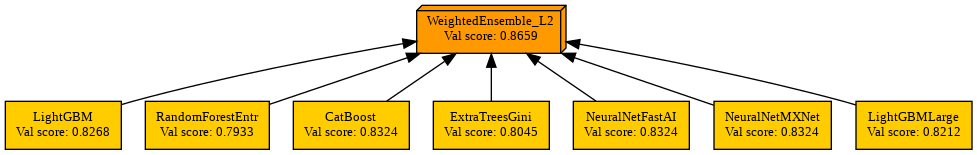

In [ ]:
# アンサンブル学習の結果をIPythonで表示する
!apt install libgraphviz-dev
!pip install pygraphviz
from IPython.display import Image

Image(predictor.plot_ensemble_model())

さらに詳しい実行結果を確認すると、今回取り扱う機械学習タスクが二値分類であると認識していることが分かります。また、カテゴリか数字かなどの変数の特徴も自動で捉えています。

In [ ]:
print(predictor.problem_type)
print(predictor.feature_metadata)

binary
('category', [])                    : 3 | ['Ticket', 'Cabin', 'Embarked']
('float', [])                       : 2 | ['Age', 'Fare']
('int', [])                         : 3 | ['Pclass', 'SibSp', 'Parch']
('int', ['binned', 'text_special']) : 9 | ['Name.char_count', 'Name.word_count', 'Name.capital_ratio', 'Name.lower_ratio', 'Name.special_ratio', ...]
('int', ['bool'])                   : 1 | ['Sex']
('int', ['text_ngram'])             : 9 | ['__nlp__.henry', '__nlp__.john', '__nlp__.master', '__nlp__.miss', '__nlp__.mr', ...]


AutoGluonで作成した前処理後のデータを確認すると、`__nlp__.mr`や`__nlp__.mrs`といったカテゴリカルなデータを作成していることが分かります。自然言語処理が必要となるようなデータの場合でも自動で特徴量を生成してくれるため、作業時間が短縮できます。

In [ ]:
predictor.transform_features()

,Pclass,Sex,Age,SibSp,Parch,Fare,Ticket,Cabin,Embarked,Name.char_count,Name.word_count,Name.capital_ratio,Name.lower_ratio,Name.special_ratio,Name.symbol_count..,Name.symbol_ratio..,Name.symbol_count.,Name.symbol_ratio.,__nlp__.henry,__nlp__.john,__nlp__.master,__nlp__.miss,__nlp__.mr,__nlp__.mr william,__nlp__.mrs,__nlp__.william,__nlp__._total_
153,3,1,40.5,0,2,14.5000,NaN,0,3,7,2,1,9,0,0,2,2,8,0,0,0,0,1,0,0,0,1
752,3,1,33.0,0,0,9.5000,NaN,0,3,7,2,5,6,0,0,1,2,7,0,0,0,0,1,0,0,0,1
610,3,0,39.0,1,5,31.2750,72,0,3,9,4,0,9,1,0,0,4,2,0,0,0,0,0,0,1,0,1
200,3,1,28.0,0,0,9.5000,NaN,0,3,7,2,7,5,1,0,2,2,8,0,0,0,0,1,0,0,0,1
310,1,0,24.0,0,0,83.1583,15,NaN,1,7,1,1,9,0,0,2,1,1,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,1,1,71.0,0,0,34.6542,NaN,NaN,1,4,1,6,5,3,0,4,1,6,0,0,0,0,1,0,0,0,1
440,2,0,45.0,1,1,26.2500,107,0,3,9,3,2,5,5,0,0,3,5,0,0,0,0,0,0,1,0,1
75,3,1,25.0,0,0,7.6500,NaN,42,3,3,1,7,2,4,0,5,1,8,0,0,0,0,1,0,0,0,1
575,3,1,19.0,0,0,14.5000,79,0,3,2,0,3,4,5,0,7,0,1,0,0,0,0,1,0,0,0,1


### 予測
テストデータを予測して、Kaggleへの提出ファイルを作成します。

In [ ]:
y_pred = predictor.predict(test_df)
submit_df = pd.DataFrame(y_pred)
submit_df['PassengerId'] = test_df_tmp
submit_df

,Survived,PassengerId
0,0,892
1,0,893
2,0,894
3,0,895
4,0,896
...,...,...
413,0,1305
414,1,1306
415,0,1307
416,0,1308


In [ ]:
# このcsvをkaggleに提出する
submit_df.to_csv('submission.csv', index=False)

## その他の機能と応用

### モデル構築で重視する指標の設定

AutoGluonでは設定値を指定し、学習モデルの精度と推論時間、ディスク使用量のバランスをモデルの利用用途に応じて最適化することができます。今回は良い結果を出すことを重視する設定値である`presets='best_quality'`を指定してみます。  

In [ ]:
predictor_best_quality = TabularPredictor(label='Survived', eval_metric='accuracy').fit(train_df, presets='best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20210919_153859/"
Presets specified: ['best_quality']
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20210919_153859/"
AutoGluon Version:  0.3.1
Train Data Rows:    891
Train Data Columns: 10
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    12614.74 MB
	Train Data (Original)  Memory Usage: 0.31 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in t

In [ ]:
predictor_best_quality.leaderboard()

                      model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0           LightGBM_BAG_L2   0.877666       2.976875   96.547154                0.091797           3.848535            2       True         16
1       WeightedEnsemble_L3   0.877666       2.979321   97.225967                0.002446           0.678813            3       True         26
2           CatBoost_BAG_L2   0.876543       2.947215  101.766672                0.062137           9.068053            2       True         19
3            XGBoost_BAG_L2   0.875421       2.963735   97.724879                0.078657           5.026260            2       True         23
4         LightGBMXT_BAG_L2   0.868687       2.977085   95.651146                0.092007           2.952528            2       True         15
5    NeuralNetFastAI_BAG_L1   0.866442       0.194268   14.652952                0.194268          14.652952            1       True    

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBM_BAG_L2,0.877666,2.976875,96.547154,0.091797,3.848535,2,True,16
1,WeightedEnsemble_L3,0.877666,2.979321,97.225967,0.002446,0.678813,3,True,26
2,CatBoost_BAG_L2,0.876543,2.947215,101.766672,0.062137,9.068053,2,True,19
3,XGBoost_BAG_L2,0.875421,2.963735,97.724879,0.078657,5.026260,2,True,23
4,LightGBMXT_BAG_L2,0.868687,2.977085,95.651146,0.092007,2.952528,2,True,15
5,NeuralNetFastAI_BAG_L1,0.866442,0.194268,14.652952,0.194268,14.652952,1,True,10
6,WeightedEnsemble_L2,0.866442,0.196439,15.464878,0.002171,0.811926,2,True,14
7,LightGBMLarge_BAG_L2,0.865320,2.982609,103.563222,0.097531,10.864603,2,True,25
8,NeuralNetFastAI_BAG_L2,0.865320,3.127911,107.351658,0.242832,14.653039,2,True,22
9,NeuralNetMXNet_BAG_L2,0.863075,4.380262,134.619308,1.495184,41.920689,2,True,24


また、テキストデータの自動特徴量生成を無効にする`presets='ignore_text'`を設定することで、この機能が結果にどの程度影響を与えているのか見てみましょう。

In [ ]:
predictor_ignore_text = TabularPredictor(label='Survived', eval_metric='accuracy').fit(train_df, presets='ignore_text')

No path specified. Models will be saved in: "AutogluonModels/ag-20210919_154214/"
Presets specified: ['ignore_text']
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20210919_154214/"
AutoGluon Version:  0.3.1
Train Data Rows:    891
Train Data Columns: 10
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    12612.08 MB
	Train Data (Original)  Memory Usage: 0.31 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to

In [ ]:
predictor_ignore_text.leaderboard()

                  model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2   0.860335       0.233455  10.622888                0.000848           0.414573            2       True         14
1       NeuralNetFastAI   0.843575       0.020155   1.375315                0.020155           1.375315            1       True         10
2         LightGBMLarge   0.837989       0.011039   0.430690                0.011039           0.430690            1       True         13
3        NeuralNetMXNet   0.832402       0.183425   6.852694                0.183425           6.852694            1       True         12
4              CatBoost   0.821229       0.006920   1.282176                0.006920           1.282176            1       True          7
5              LightGBM   0.821229       0.011858   0.340775                0.011858           0.340775            1       True          4
6               XGBoost   0

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.860335,0.233455,10.622888,0.000848,0.414573,2,True,14
1,NeuralNetFastAI,0.843575,0.020155,1.375315,0.020155,1.375315,1,True,10
2,LightGBMLarge,0.837989,0.011039,0.430690,0.011039,0.430690,1,True,13
3,NeuralNetMXNet,0.832402,0.183425,6.852694,0.183425,6.852694,1,True,12
4,CatBoost,0.821229,0.006920,1.282176,0.006920,1.282176,1,True,7
5,LightGBM,0.821229,0.011858,0.340775,0.011858,0.340775,1,True,4
6,XGBoost,0.810056,0.009322,0.280843,0.009322,0.280843,1,True,11
7,RandomForestEntr,0.793296,0.107348,0.843243,0.107348,0.843243,1,True,6
8,LightGBMXT,0.787709,0.011067,0.267440,0.011067,0.267440,1,True,3
9,RandomForestGini,0.787709,0.107467,0.752496,0.107467,0.752496,1,True,5


「タイタニックデータでAutoML」章の「モデルの学習」節で学習させたモデルの精度は0.865922でしたが、テキストデータの自動特徴量生成を無効にした場合、精度が0.860335に下がりました。テキストデータの自動特徴量生成によって、精度が向上していたことが分かります。

以上でAutoGluonを使用したタイタニックの生存予測は終了です。MNISTを使用した画像分類については「AutoGluon_MNIST.ipynb」を確認してください。